In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from utils import *

In [2]:
df = pd.read_csv('../HMM_randomportfolio.csv')
df.pricingdate = df.pricingdate.astype('datetime64')
df = df.tail(1000)
df = df.set_index(df.pricingdate).drop('pricingdate', axis=1)
df

,priceclose,r1,signal
pricingdate,,,
2018-06-12,1293.170013,0.002628,1
2018-06-13,1296.170003,0.002320,1
2018-06-14,1303.909986,0.005971,1
2018-06-15,1308.450022,0.003482,1
2018-06-18,1299.859995,-0.006565,0
...,...,...,...
2022-05-24,1871.590002,0.002630,1
2022-05-25,1913.690022,0.022494,1
2022-05-26,1923.819968,0.005293,1


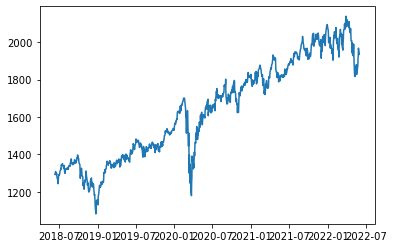

In [3]:
plt.plot(df.priceclose)

In [4]:
def initialize_parameters(n_hidden, n_visible, random_state = 30):
    random.seed(random_state)
    
    A = rand_mat(n_hidden, n_hidden)        
    B = rand_mat(n_hidden,n_visible)    
    pi = np.array([np.mean(A[:,i]) for i in range(n_hidden)])

    return A, B, pi

In [5]:
S = ['B','H','S'] # buy, hold, sell

In [6]:
n_visible = len(df.signal.unique())
n_hidden = len(S)

In [7]:
A, B, pi = initialize_parameters(n_hidden, n_visible, 30)

In [8]:
def forward(V, A, B, pi):
    T = V.shape[0]
    N = A.shape[0]
    
    alpha = np.zeros((T,N))
    alpha[0] = pi[0] * B[:,V[0]]  
    for t in range(0,T-1): alpha[t+1] = np.array([alpha[t,:].dot(A[:,j]) * (B[j,V[t+1]]) for j in range(N)])
            
    return alpha

In [9]:
def backward(V, A, B):
    T = V.shape[0]
    N = A.shape[0]
    
    beta = np.zeros((T,N))
    beta[T-1] = np.ones((N))
    for t in range(T-2, -1, -1): beta[t] = np.array([(beta[t+1,:] * B[:,V[t+1]]).dot(A[j,:]) for j in range(N)])
            
    return beta

In [10]:
def baum_welch(V, A, B, pi, max_iter=100, epsilon=5e-3):
    T = V.shape[0]
    N = A.shape[0]
    
    # initialization: for the first iteration, our estimated parameters will be the initial ones
    A_bar = A
    B_bar = B
    pi_bar = pi
    
    for iteration in range(max_iter):
        alpha = forward(V, A_bar, B_bar, pi_bar)
        beta = backward(V, A_bar, B_bar)

        xi = np.zeros((T, N, N))
        for t in range(T-1):
            denominator = sum(alpha[t,:].dot(A_bar[:,:]) * B_bar[:,V[t+1]] * beta[t+1,:])
            for i in range(N):
                for j in range(N):
                    numerator = alpha[t,i] * A_bar[i,j] * (B_bar[j,V[t+1]]) * beta[t+1,j] 
                    xi[t,i,j] = numerator / denominator 

        # note: gamma can be also computed as
        gamma = np.zeros((T,N))
        for t in range(T): gamma[t] = np.array([sum(xi[t,i,:]) for i in range(N)])

        # expectation-maximization step
        pi_bar = np.array([gamma[0,i] for i in range(N)])

        prev = [A_bar, B_bar, pi_bar]
               
        A_bar = np.zeros((N,N))
        for i in range(N): A_bar[i] = np.array([xi[:-1,i,j].sum() / gamma[:-1,i].sum() for j in range(N)])

        B_bar = np.zeros(B.shape)
        for j in range(B.shape[0]):
            for k in range(B.shape[1]):
                # we need to define a list of times t_bar where V[t] is equal to k
                t_bar = [0,0]
                for i in sorted(V.unique()): t_bar[i] = [t for t in range(T) if V[t]==k]
                B_bar[j,k] = sum([gamma[t,j] for t in t_bar[k]]) / gamma[:,j].sum()
        
        A_delta = delta(A_bar, prev[0])
        B_delta = delta(B_bar, prev[1])
        pi_delta = delta(pi_bar, prev[2])
        
        e = A_delta + B_delta + pi_delta
        
        print(f'iteration {iteration} - delta {e}')
        if e < epsilon: break

    return {'A_hat': A_bar, 'B_hat': B_bar, 'pi_hat': pi_bar}

In [11]:
est= baum_welch(df.signal, A, B, pi)
est

/tmp/ipykernel_68960/1898917675.py:20: RuntimeWarning: invalid value encountered in double_scalars
  xi[t,i,j] = numerator / denominator


iteration 0 - delta nan
iteration 1 - delta nan
iteration 2 - delta nan
iteration 3 - delta nan
iteration 4 - delta nan
iteration 5 - delta nan
iteration 6 - delta nan
iteration 7 - delta nan
iteration 8 - delta nan
iteration 9 - delta nan
iteration 10 - delta nan
iteration 11 - delta nan
iteration 12 - delta nan
iteration 13 - delta nan
iteration 14 - delta nan
iteration 15 - delta nan
iteration 16 - delta nan
iteration 17 - delta nan
iteration 18 - delta nan
iteration 19 - delta nan
iteration 20 - delta nan
iteration 21 - delta nan
iteration 22 - delta nan
iteration 23 - delta nan
iteration 24 - delta nan
iteration 25 - delta nan
iteration 26 - delta nan
iteration 27 - delta nan
iteration 28 - delta nan
iteration 29 - delta nan
iteration 30 - delta nan
iteration 31 - delta nan
iteration 32 - delta nan
iteration 33 - delta nan
iteration 34 - delta nan
iteration 35 - delta nan
iteration 36 - delta nan
iteration 37 - delta nan
iteration 38 - delta nan
iteration 39 - delta nan
iteration 

{'A_hat': array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]),
 'B_hat': array([[nan, nan],
        [nan, nan],
        [nan, nan]]),
 'pi_hat': array([nan, nan, nan])}

In [12]:
len(pi.shape)

1

In [13]:
def viterbi(V, a, b, initial_distribution):
    T = V.shape[0]
    M = a.shape[0]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t]])
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
    result = []
    for s in S:
        if s == 0:
            result.append("A")
        else:
            result.append("B")
 
    return result

In [14]:
f =np.zeros((1,3))